In [ ]:
pip install statsmodels pandas numpy matplotlib


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/2025 Units Forecaast.csv', parse_dates=['month'])
df.set_index('month', inplace=True)

# Ensure data is sorted
df = df.sort_index()

# Check data
print(df.head())


            units_sold
month                 
2022-07-31        1331
2022-08-31        1197
2022-09-30        1913
2022-10-31        2042
2022-11-30        4388


# **Key Metrics & What They Indicate**
AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion)

These measure the model's goodness-of-fit while penalizing complexity.
Lower values indicate a better model.
Use case: When comparing your three models, choose the one with the lowest AIC/BIC.

Log-Likelihood

Represents how well the model explains the data.
Higher values (closer to zero) suggest a better fit.
Use case: Helps in conjunction with AIC/BIC to assess fit.
Model Coefficients & Significance
AR (Autoregressive) Coefficients (p, P)

If significant (p-values < 0.05), past values meaningfully predict future ones.
Large absolute values could indicate strong dependency on previous observations.
MA (Moving Average) Coefficients (q, Q)

Significant values suggest that past forecast errors influence future values.
If insignificant (p-value > 0.05), consider adjusting q or Q.
Seasonal Terms (P, D, Q, s)

If the seasonal components (P, Q) are not significant, you might reconsider the seasonal structure.
D = 1 ensures the model accounts for seasonal differences.
Residual Diagnostics
Jarque-Bera / Normality Test

If p-value < 0.05 → Residuals are not normally distributed (which is bad).
If p-value > 0.05 → Residuals are normal (which is good).
Heteroskedasticity (H)

If close to 1 → Constant variance (good).
If much higher/lower → Model might be missing a key pattern.
Ljung-Box Test (Q-Stat)

Tests for autocorrelation in residuals.
If p-value > 0.05 → Residuals are uncorrelated (good).
If p-value < 0.05 → Residuals have autocorrelation (bad).


In [ ]:
#Sarimax seasonal arima. Want to mess with periods to make monthly
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(df['units_sold'],
                       order=(2,1,1),        # p, d, q
                       seasonal_order=(1,1,1,12),  # P, D, Q, seasonal_period (12 for yearly)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model
sarima_result = sarima_model.fit()

# Print summary
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                         units_sold   No. Observations:                   30
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -22.875
Date:                            Wed, 12 Feb 2025   AIC                             57.751
Time:                                    13:09:31   BIC                             52.342
Sample:                                07-31-2022   HQIC                            46.879
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3889   1422.388     -0.000      1.000   -2788.218    2787.440
ar.L2          0.1705    394.609   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


1. Past values are not meaningfully predicting future ones.
2. insignificant MA coefficient, q or Q might need tuned. Past forecast errors influence future values when significant, this is what you want.
3. D = 1 makes sure that the season effect is accounted for. Almost significant Q, but not close enough.
---> was thinking seasonality might be 6***(twice a year) or quarterly**
4. Jarque Bera - residuals re normal, good,
Ljung Box - Residuals are uncorrelated, good.
5. Slightly outside of acceptable bounds for skew (.5 to -.5)
6. Kurtosis < 3 (Platykurtic) → Fewer extreme values than normal.
Indicates model overestimates volatility (flatter peak, lighter tails).
✅ Goal: Kurtosis close to 3 (acceptable range: 2.5 - 3.5).

Testing different periods first, then will try to tame the skew/ kurtosis: iterates through the different periods to find the best seasonal:

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # Import SARIMAX here
for s in [12, 6, 3]: # Removed 1 from the list of seasonal periods
    model = SARIMAX(df['units_sold'], order=(2,1,1), seasonal_order=(1,1,1,s))
    result = model.fit()
    print(f"Seasonal Period: {s} - AIC: {result.aic}, BIC: {result.bic}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: C

Seasonal Period: 12 - AIC: 267.4586756294496, BIC: 272.4579556937869


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA p

Seasonal Period: 6 - AIC: 367.51462806798384, BIC: 374.3275933635587
Seasonal Period: 3 - AIC: 446.655535055556, BIC: 454.20411428368493


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


semi annual has the lowest aic and bic

In [ ]:
#Sarimax seasonal arima. Want to mess with periods to make monthly
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(df['units_sold'],
                       order=(1,1,1),        # p, d, q
                       seasonal_order=(0,2,0,3),  # P, D, Q, seasonal_period (12 for yearly)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model
sarima_result = sarima_model.fit()

# Print summary
print(sarima_result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                         units_sold   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(0, 2, [], 3)   Log Likelihood                -901.552
Date:                            Wed, 12 Feb 2025   AIC                           1809.104
Time:                                    15:14:41   BIC                           1816.949
Sample:                                12-31-2015   HQIC                          1812.280
                                     - 01-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7744      0.159     -4.857      0.000      -1.087      -0.462
ma.L1          0.4896      0.179   

Mean Absolute Error (MAE): 301.4467647484761
Root Mean Squared Error (RMSE): 401.0741995414971

Actual vs Forecasted Results:
            Actual     Forecast
2023-04-30    1591  1386.657733
2023-05-31    1337  2195.624578
2023-06-30    3172  2966.030256
2023-07-31    1332  1363.071625
2023-08-31    1159  1290.657292
2023-09-30    1508  2034.519340
2023-10-31    1668  1710.265056
2023-11-30    3925  3523.114164
2023-12-31    1956  2172.852277
2024-01-31    1752  1537.110084
2024-02-29    1369  1330.937058
2024-03-31    1684  2032.442599
2024-04-30    1168  1425.086618
2024-05-31    1570  2588.312748
2024-06-30    2571  2609.959734
2024-07-31     846  1348.520255
2024-08-31    1113  1228.881483
2024-09-30    1852  1957.784213
2024-10-31    2027  1533.577453
2024-11-30    3202  3117.069056
2024-12-31    2866  2251.178044
2025-01-31    1215  1394.524855


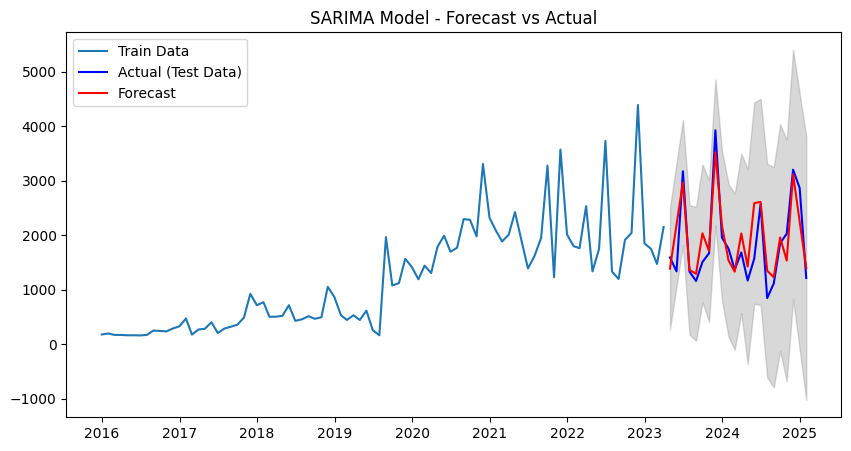

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have the 'df' DataFrame and the data is properly indexed by datetime

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define SARIMA model (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(train_data['units_sold'],
                       order=(2,1,1),        # p, d, q
                       seasonal_order=(1,1,1,6),  # P, D, Q, seasonal_period (12 for yearly)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model
sarima_result = sarima_model.fit()

# Make forecast on the test set
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean  # Forecasted values
forecast_conf_int = forecast.conf_int()  # Confidence intervals

# Calculate errors
mae = mean_absolute_error(test_data['units_sold'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['units_sold'], forecast_mean))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Print actual vs forecasted results
results_df = pd.DataFrame({
    'Actual': test_data['units_sold'],
    'Forecast': forecast_mean
})
print("\nActual vs Forecasted Results:")
print(results_df)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['units_sold'], label="Train Data")
plt.plot(test_data.index, test_data['units_sold'], label="Actual (Test Data)", color='blue')
plt.plot(test_data.index, forecast_mean, label="Forecast", color='red')
plt.fill_between(test_data.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMA Model - Forecast vs Actual")
plt.show()


In [ ]:

# Export results to CSV
results_df.to_csv('forecasted_vs_actual_results.csv')


Better! now have a significant AR term, skew is within acceptable ranges, still pasing LJ and JB, finally getting results for heteroskedaskity (even if they're over 1); now transforming variable:

In [ ]:
#box cox transformation (in theory auto applies best transformation for you if no negative values in sequence)
from scipy.stats import boxcox
df['units_sold_transformed'], lambda_ = boxcox(df['units_sold'])


In [ ]:
df['units_sold_transformed'] = np.log1p(df['units_sold'])

In [ ]:
#Sarimax seasonal arima. Want to mess with periods to make monthly
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(df['units_sold'],
                       order=(2,1,1),        # p, d, q
                       seasonal_order=(1,1,1,6),  # P, D, Q, seasonal_period (12 for yearly)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model
sarima_result = sarima_model.fit()

# Print summary
print(sarima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                        units_sold   No. Observations:                   30
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -345.713
Date:                           Wed, 12 Feb 2025   AIC                            703.427
Time:                                   14:04:50   BIC                            707.675
Sample:                               07-31-2022   HQIC                           703.381
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2299         -0        inf      0.000      -0.230      -0.230
ar.L2         -0.0421         -0        inf

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


In [ ]:
# Forecast the next 12 periods (months in this case)
forecast_steps = 12
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Extract predicted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Print forecast values
print("Forecasted Values:")
print(forecast_mean)

# Print confidence intervals
print("\nConfidence Intervals:")
print(forecast_conf_int)


Forecasted Values:
2023-04-30    1386.657733
2023-05-31    2195.624578
2023-06-30    2966.030256
2023-07-31    1363.071625
2023-08-31    1290.657292
2023-09-30    2034.519340
2023-10-31    1710.265056
2023-11-30    3523.114164
2023-12-31    2172.852277
2024-01-31    1537.110084
2024-02-29    1330.937058
2024-03-31    2032.442599
Freq: ME, Name: predicted_mean, dtype: float64

Confidence Intervals:
            lower units_sold  upper units_sold
2023-04-30        278.341404       2494.974063
2023-05-31       1061.393125       3329.856031
2023-06-30       1819.173904       4112.886608
2023-07-31        174.562733       2551.580517
2023-08-31         63.252448       2518.062135
2023-09-30        774.416727       3294.621953
2023-10-31        409.262074       3011.268039
2023-11-30       2188.183906       4858.044422
2023-12-31        805.512022       3540.192532
2024-01-31        137.224899       2936.995270
2024-02-29       -100.753748       2762.627865
2024-03-31        569.769242       

In [ ]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float('inf')
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df['units_sold'], order=param, seasonal_order=param_seasonal)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

print(f"Best Model: {best_params} with AIC: {best_aic}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodel

Best Model: ((1, 1, 1), (2, 1, 0, 12)) with AIC: 339.01488649529944


Best Model: ((1, 1, 1), (0, 2, 0, 12)) with AIC: 6.0 (non pandemic data set)

All data: 1 1 1    2  1 0  12

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model with the best parameters
sarima_model = SARIMAX(df['units_sold'],
                       order=(1,1,1),         # p, d, q
                       seasonal_order=(2,1,0,12),  # P, D, Q, s (12 for yearly seasonality)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Print model summary
print(sarima_result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                          units_sold   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -562.805
Date:                             Wed, 12 Feb 2025   AIC                           1135.611
Time:                                     16:02:18   BIC                           1146.994
Sample:                                 12-31-2015   HQIC                          1140.143
                                      - 01-31-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1066      0.146     -0.732      0.464      -0.392       0.179
ma.L1         -0.7526      

Mean Absolute Error (MAE): 375.6207938894697
Root Mean Squared Error (RMSE): 514.0002903413179

Actual vs Forecasted Results:
            Actual     Forecast
2023-04-30    1591  1820.535104
2023-05-31    1337  1632.897297
2023-06-30    3172  2167.820101
2023-07-31    1332  1290.242382
2023-08-31    1159  1404.076326
2023-09-30    1508  2597.639722
2023-10-31    1668  1312.377601
2023-11-30    3925  3753.798730
2023-12-31    1956  1722.986769
2024-01-31    1752  1558.150667
2024-02-29    1369  1434.344155
2024-03-31    1684  2227.925603
2024-04-30    1168  1246.807209
2024-05-31    1570  1494.163529
2024-06-30    2571  3094.610374
2024-07-31     846  1094.663674
2024-08-31    1113  1022.030195
2024-09-30    1852  1883.627797
2024-10-31    2027  1616.880430
2024-11-30    3202  4003.912103
2024-12-31    2866  1588.019533
2025-01-31    1215  1470.088038


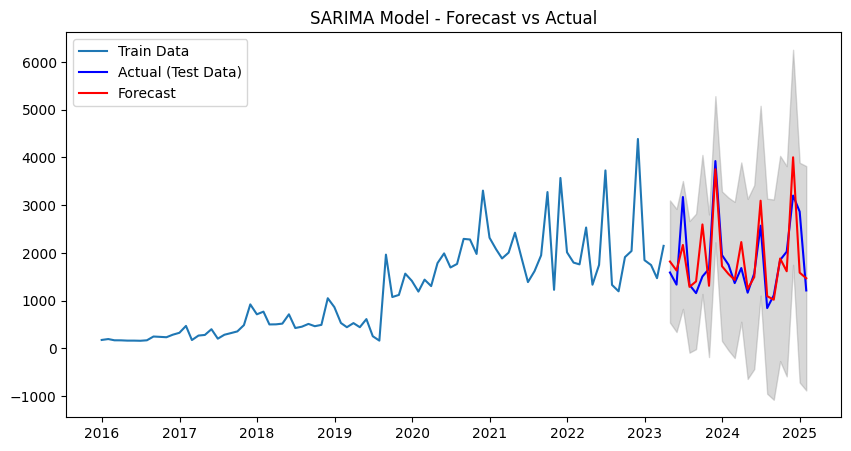

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have the 'df' DataFrame and the data is properly indexed by datetime

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define SARIMA model (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(train_data['units_sold'],
                       order=(1,1,1),        # p, d, q
                       seasonal_order=(2,1,0,12),  # P, D, Q, seasonal_period (12 for yearly)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model
sarima_result = sarima_model.fit()

# Make forecast on the test set
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean  # Forecasted values
forecast_conf_int = forecast.conf_int()  # Confidence intervals

# Calculate errors
mae = mean_absolute_error(test_data['units_sold'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['units_sold'], forecast_mean))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Print actual vs forecasted results
results_df = pd.DataFrame({
    'Actual': test_data['units_sold'],
    'Forecast': forecast_mean
})
print("\nActual vs Forecasted Results:")
print(results_df)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['units_sold'], label="Train Data")
plt.plot(test_data.index, test_data['units_sold'], label="Actual (Test Data)", color='blue')
plt.plot(test_data.index, forecast_mean, label="Forecast", color='red')
plt.fill_between(test_data.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMA Model - Forecast vs Actual")
plt.show()


we're gonna continue witht he diagnostics below, but the only reason this came out as the best model is because half the metrics are missing. I think the best model so far has actually been a 211 1116 model ; 111  1113 is a close second (quarterly seasonality)

In [ ]:
import matplotlib.pyplot as plt
sarima_result.plot_diagnostics(figsize=(12, 8))
plt.show()


ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='month'>

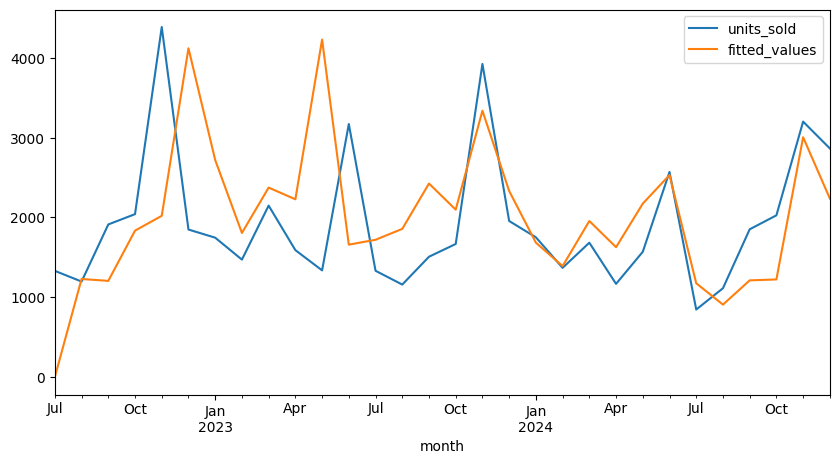

In [ ]:
df['fitted_values'] = sarima_result.fittedvalues
df[['units_sold', 'fitted_values']].plot(figsize=(10,5))


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df['units_sold'][1:], sarima_result.fittedvalues[1:]))
print(f"RMSE: {rmse}")


RMSE: 981.4837154620508


In [ ]:
import pandas as pd

# Forecast for 12 months (2025)
forecast_steps = 12
forecast_sarima = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='M')[1:]

# Create a DataFrame to store the forecast results
forecast_table = pd.DataFrame({
    'Month/Year': forecast_index.strftime('%b-%Y'),
    'Predicted Units Sold': forecast_sarima.predicted_mean,
    'Lower Bound (95%)': forecast_sarima.conf_int()['lower units_sold'],
    'Upper Bound (95%)': forecast_sarima.conf_int()['upper units_sold']
})

# Export to CSV
forecast_table.to_csv('sarima_forecast_2025.csv', index=False)

# Print out the forecast table
print(forecast_table)


           Month/Year  Predicted Units Sold  Lower Bound (95%)  \
2025-01-31   Jan-2025           1484.705417         339.917176   
2025-02-28   Feb-2025           1687.716869         499.264820   
2025-03-31   Mar-2025           1387.037234         133.973876   
2025-04-30   Apr-2025           1143.613938        -112.188688   
2025-05-31   May-2025           1812.024288         545.644242   
2025-06-30   Jun-2025           2211.490802         950.178825   
2025-07-31   Jul-2025            759.718258        -504.617945   
2025-08-31   Aug-2025            985.562682        -251.415455   
2025-09-30   Sep-2025           2136.130138         911.121740   
2025-10-31   Oct-2025           2136.431768         912.834024   
2025-11-30   Nov-2025           2951.019911        1731.110056   
2025-12-31   Dec-2025           3163.466378        1943.627694   

            Upper Bound (95%)  
2025-01-31        2629.493658  
2025-02-28        2876.168919  
2025-03-31        2640.100593  
2025-04-30   

<ipython-input-6-adf2225d9ac7>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='M')[1:]


# Training Testing Validation Segments
Now i want to try proper forecasting or whatever, where you do training/testing/validation segments on the model

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/2025 Units Forecaast.csv', parse_dates=['month'])
df.set_index('month', inplace=True)

# Ensure data is sorted
df = df.sort_index()

# Check data
print(df.head())


            units_sold
month                 
2015-12-31         178
2016-01-31         197
2016-02-29         171
2016-03-31         170
2016-04-30         164


<ipython-input-56-86dd6e2505a0>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')


Optimization terminated successfully.
         Current function value: 6.436466
         Iterations: 4
         Function evaluations: 228
Mean Absolute Error (MAE): 279.425444509714
Root Mean Squared Error (RMSE): 379.8052565503928


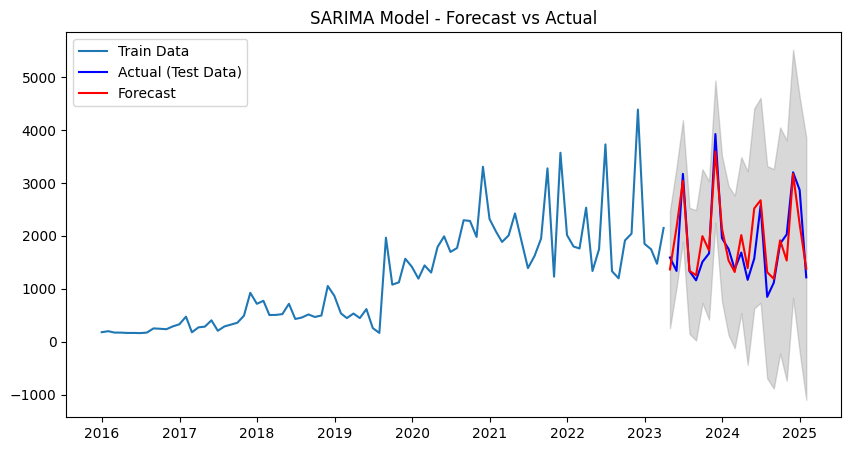

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure datetime index with frequency
df.index = pd.to_datetime(df.index)
df = df.asfreq('M')

# Split data
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define SARIMA model
sarima_model = SARIMAX(train_data['units_sold'],
                       order=(2,1,1),
                       seasonal_order=(1,1,1,6),  # Adjust if needed
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model with more iterations
sarima_result = sarima_model.fit(maxiter=1000, method='powell')

# Forecast
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Calculate errors
mae = mean_absolute_error(test_data['units_sold'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['units_sold'], forecast_mean))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['units_sold'], label="Train Data")
plt.plot(test_data.index, test_data['units_sold'], label="Actual (Test Data)", color='blue')
plt.plot(test_data.index, forecast_mean, label="Forecast", color='red')
plt.fill_between(test_data.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMA Model - Forecast vs Actual")
plt.show()


<ipython-input-58-ff621f47cbb7>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')


Optimization terminated successfully.
         Current function value: 6.436466
         Iterations: 4
         Function evaluations: 228
Mean Absolute Error (MAE): 279.425444509714
Root Mean Squared Error (RMSE): 379.8052565503928

Actual vs Forecasted Results:
            Actual     Forecast
2023-04-30    1591  1364.472876
2023-05-31    1337  2158.702949
2023-06-30    3172  3039.346303
2023-07-31    1332  1337.894449
2023-08-31    1159  1253.873733
2023-09-30    1508  1994.827230
2023-10-31    1668  1723.905609
2023-11-30    3925  3594.647646
2023-12-31    1956  2138.177460
2024-01-31    1752  1535.096170
2024-02-29    1369  1316.767418
2024-03-31    1684  2014.579949
2024-04-30    1168  1390.190671
2024-05-31    1570  2519.127442
2024-06-30    2571  2672.656064
2024-07-31     846  1312.946013
2024-08-31    1113  1187.143630
2024-09-30    1852  1914.669358
2024-10-31    2027  1533.784113
2024-11-30    3202  3173.750887
2024-12-31    2866  2218.152635
2025-01-31    1215  1379.683273


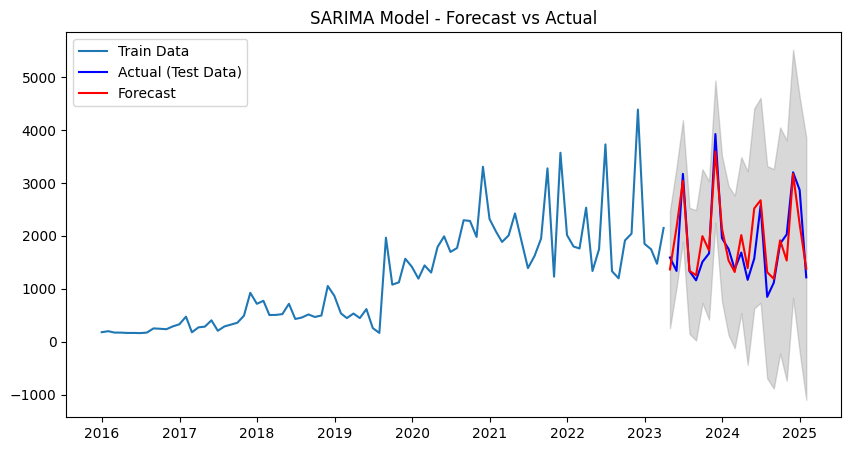

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure datetime index with frequency
df.index = pd.to_datetime(df.index)
df = df.asfreq('M')

# Split data
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define SARIMA model
sarima_model = SARIMAX(train_data['units_sold'],
                       order=(2,1,1),
                       seasonal_order=(1,1,1,6),  # Adjust if needed
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit model with more iterations
sarima_result = sarima_model.fit(maxiter=1000, method='powell')

# Forecast
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Calculate errors
mae = mean_absolute_error(test_data['units_sold'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['units_sold'], forecast_mean))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Print actual vs forecasted results
results_df = pd.DataFrame({
    'Actual': test_data['units_sold'],
    'Forecast': forecast_mean
})
print("\nActual vs Forecasted Results:")
print(results_df)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['units_sold'], label="Train Data")
plt.plot(test_data.index, test_data['units_sold'], label="Actual (Test Data)", color='blue')
plt.plot(test_data.index, forecast_mean, label="Forecast", color='red')
plt.fill_between(test_data.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMA Model - Forecast vs Actual")
plt.show()

# Next Steps:
ADDING EXOGENOUS VARIABLES - f seasonality alone isn’t capturing patterns, consider adding external predictors (exog), such as:

Holidays (e.g., Black Friday spikes)
Marketing spend / promotions

# Exponential Smoothing (ETS) can often provide a better fit for time series data with trend and seasonality components. Let's implement it using statsmodels' ExponentialSmoothing.

In [ ]:
print(df)

            units_sold
month                 
2022-07-31        1331
2022-08-31        1197
2022-09-30        1913
2022-10-31        2042
2022-11-30        4388
2022-12-31        1849
2023-01-31        1747
2023-02-28        1472
2023-03-31        2149
2023-04-30        1591
2023-05-31        1337
2023-06-30        3172
2023-07-31        1332
2023-08-31        1159
2023-09-30        1508
2023-10-31        1668
2023-11-30        3925
2023-12-31        1956
2024-01-31        1752
2024-02-29        1369
2024-03-31        1684
2024-04-30        1168
2024-05-31        1570
2024-06-30        2571
2024-07-31         846
2024-08-31        1113
2024-09-30        1852
2024-10-31        2027
2024-11-30        3202
2024-12-31        2866


In [ ]:
#Check Trend & Seasonality:
#If your data has both, we’ll use the Holt-Winters method.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming df has 'date' and 'sales' columns
df = df.set_index('month')
df.index = pd.to_datetime(df.index)

# Fit Exponential Smoothing Model
model = ExponentialSmoothing(df['units_sold'],
                             trend='add',       # Use 'mul' if trend grows exponentially
                             seasonal='add',    # Use 'mul' if seasonal effect grows over time
                             seasonal_periods=12).fit()

# Forecast for next 12 months
forecast = model.forecast(12)

# Plot Actual vs Forecast
plt.figure(figsize=(10,5))
plt.plot(df['units_sold'], label='Actual Sales')
plt.plot(forecast, label='Forecasted Sales', linestyle='dashed')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()

# Print January 2025 Forecast
print("Forecast for January 2025:", forecast.loc['2025-01'])


KeyError: "None of ['month'] are in the columns"

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


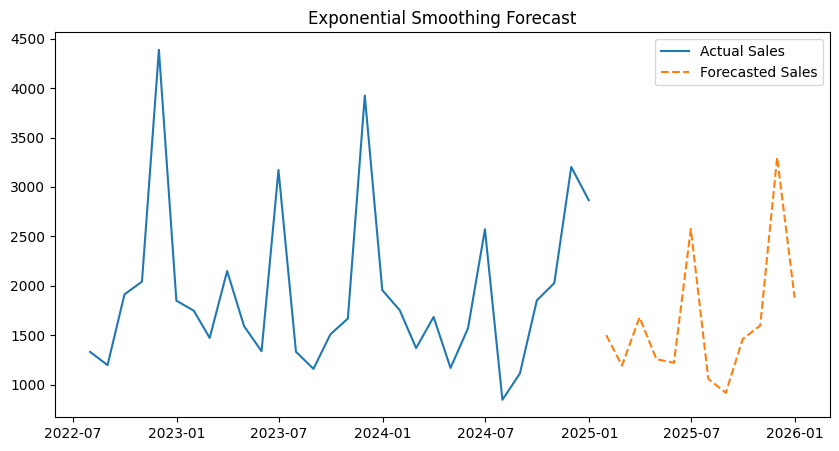

Forecast for January 2025: 2025-01-31    1500.477807
Freq: ME, dtype: float64


In [ ]:
#Check Trend & Seasonality:
#If your data has both, we’ll use the Holt-Winters method.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 'month' is likely already the index, so we convert it to datetime
df.index = pd.to_datetime(df.index)

# Fit Exponential Smoothing Model
model = ExponentialSmoothing(df['units_sold'],
                             trend='add',       # Use 'mul' if trend grows exponentially
                             seasonal='mul',    # Use 'mul' if seasonal effect grows over time
                             seasonal_periods=12).fit()

# Forecast for next 12 months
forecast = model.forecast(12)

# Plot Actual vs Forecast
plt.figure(figsize=(10,5))
plt.plot(df['units_sold'], label='Actual Sales')
plt.plot(forecast, label='Forecasted Sales', linestyle='dashed')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()

# Print January 2025 Forecast
print("Forecast for January 2025:", forecast.loc['2025-01'])

In [ ]:
# Create DataFrame for Results
forecast_df = pd.DataFrame({'Actual Sales': df['units_sold'].tail(12),
                            'Forecasted Sales': forecast})

# Reset index for display
forecast_df.index.name = 'Date'
forecast_df = forecast_df.reset_index()

# Display results
print(forecast_df)

         Date  Actual Sales  Forecasted Sales
0  2024-01-31        1752.0               NaN
1  2024-02-29        1369.0               NaN
2  2024-03-31        1684.0               NaN
3  2024-04-30        1168.0               NaN
4  2024-05-31        1570.0               NaN
5  2024-06-30        2571.0               NaN
6  2024-07-31         846.0               NaN
7  2024-08-31        1113.0               NaN
8  2024-09-30        1852.0               NaN
9  2024-10-31        2027.0               NaN
10 2024-11-30        3202.0               NaN
11 2024-12-31        2866.0               NaN
12 2025-01-31           NaN       1500.477807
13 2025-02-28           NaN       1192.527310
14 2025-03-31           NaN       1680.304763
15 2025-04-30           NaN       1257.023978
16 2025-05-31           NaN       1220.859380
17 2025-06-30           NaN       2574.469384
18 2025-07-31           NaN       1057.267703
19 2025-08-31           NaN        916.484811
20 2025-09-30           NaN       

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p=1, d=1, q=1 as an example, you can adjust based on your analysis)
arima_model = ARIMA(df['units_sold'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Get the forecast for the next 12 months
forecast_steps = 12
forecast_arima = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='M')[1:]

# Export the results to CSV
forecast_data = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_arima.predicted_mean,
    'Lower CI': forecast_arima.conf_int()['lower units_sold'],
    'Upper CI': forecast_arima.conf_int()['upper units_sold']
})

forecast_data.to_csv('arima_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
<ipython-input-18-926852380454>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='M')[1:]
